# Ordinary Differential Equations

In general, an ordinary differential equation looks like
\begin{equation}
f(x,g(x),g'(x),\dots, g^{(n)}(x)) = 0
\end{equation}
where $g(x)$ is the unknown.

### Trial solution
Let the trial solution be given by 
\begin{equation}
g_t(x) = h_1(x) + h_2(x,N(x,P))
\end{equation}
where $h_1(x)$ is a function that makes $g_t(x)$ satisfy a given set of conditions, $N(x,P)$ a neural network with weights and biases described by P and
$h_2(x,N(x,P))$ some expression involving the neural network.
### Cost function
\begin{equation}
c(\vec{x},P) = \frac{1}{N} \sum_{i=1}^N \left( f(x,g(x),g'(x),\dots, g^{(n)}(x)) \right)^2
\end{equation}

# Example: Exponential decay and setting up the network using Autograd
An exponential decay of a quantity is described by the equation
\begin{equation}
g'(x) = -\gamma g(x), \ \ g(0) = g_0
\end{equation}
with corresponding analytical solution 
\begin{equation}
g(x) = g_0 \exp(-\gamma x).
\end{equation}

Trial solution:
\begin{equation}
g_t(x,P) = g_0 + x \cdot N(x,P)
\end{equation}
and we have to find $P$ such that we minimize the cost function 
\begin{equation}
\text{min}_P  \frac{1}{N} \sum_{i=1}^N \left( g_t^\prime(x_i,P) - (-\gamma g_t(x_i,P)\right)^2
\end{equation}

In [16]:
import autograd.numpy as np
from autograd import grad, elementwise_grad
import autograd.numpy.random as npr
from matplotlib import pyplot as plt

def sigmoid(z):
    return 1/(1 + np.exp(-z))

# Assuming one input, hidden, and output layer
def neural_network(params, x):
 
    #Find the weights (including and biases) for the hidden and output layer.
    #Assume that params is a list of parameters for each layer.
    #The biases are the first element for each array in params,
    #and the weights are the remaning elements in each array in params.
    w_hidden = params[0]
    w_output = params[1]
    
    # Assumes input x being an one-dimensional array
    num_values = np.size(x)
    x = x.reshape(-1, num_values)
    
    # Assume that the input layer does nothing to the input x
    x_input = x
    
    ## Hidden layer:
    # Add a row of ones to include bias
    x_input = np.concatenate((np.ones((1,num_values)), x_input ), axis = 0)
    
    z_hidden = np.dot(w_hidden, x_input)
    x_hidden = sigmoid(z_hidden)
    
    ## Output layer:
    # Include bias:
    x_hidden = np.concatenate((np.ones((1,num_values)), x_hidden ), axis = 0)
    
    z_output = np.dot(w_output, x_hidden)
    x_output = z_output
    
    return x_output

# The trial solution using the deep neural network:
def g_trial(x,params, g0 = 10):
    return g0 + x*neural_network(params,x)

# The right side of the ODE:
def g(x, g_trial, gamma = 2):
    return -gamma*g_trial

# The cost function:
def cost_function(P, x):
    
    # Evaluate the trial function with the current parameters P
    g_t = g_trial(x,P)
    
    # Find the derivative w.r.t x of the neural network
    d_net_out = elementwise_grad(neural_network,1)(P,x)
    
    # Find the derivative w.r.t x of the trial function
    d_g_t = elementwise_grad(g_trial,0)(x,P)
    
    # The right side of the ODE
    func = g(x, g_t)
    err_sqr = (d_g_t - func)**2
    cost_sum = np.sum(err_sqr)
    return cost_sum / np.size(err_sqr)

# Solve the exponential decay ODE using neural network with one input, hidden, and output layer
def solve_ode_neural_network(x, num_neurons_hidden, num_iter, lmb):
    ## Set up initial weights and biases
    # For the hidden layer
    p0 = npr.randn(num_neurons_hidden, 2 )
    # For the output layer
    p1 = npr.randn(1, num_neurons_hidden + 1 ) # +1 since bias is included
    P = [p0, p1]
    print('Initial cost: %g'%cost_function(P, x))
    ## Start finding the optimal weights using gradient descent
    # Find the Python function that represents the gradient of the cost function
    # w.r.t the 0-th input argument -- that is the weights and biases in the hidden and output lay
    cost_function_grad = grad(cost_function,0)
    # Let the update be done num_iter times
    for i in range(num_iter):
        # Evaluate the gradient at the current weights and biases in P.
        # The cost_grad consist now of two arrays;
        # one for the gradient w.r.t P_hidden and
        # one for the gradient w.r.t P_output
        cost_grad = cost_function_grad(P, x)
        P[0] = P[0] - lmb * cost_grad[0]
        P[1] = P[1] - lmb * cost_grad[1]
    print('Final cost: %g'%cost_function(P, x))
    return P

def g_analytic(x, gamma = 2, g0 = 10):
    return g0*np.exp(-gamma*x)

In [28]:
# Set seed such that the weight are initialized
# with same weights and biases for every run.
npr.seed(15)

## Decide the vales of arguments to the function to solve
N = 10
x = np.linspace(0, 1, N)

## Set up the initial parameters
num_hidden_neurons = 10
num_iter = int(1e4)
lmb = 0.001

# Use the network
P = solve_ode_neural_network(x, num_hidden_neurons, num_iter, lmb)

# Print the deviation from the trial solution and true solution
res = g_trial(x,P)
res_analytical = g_analytic(x)
print('Max absolute difference: %g'%np.max(np.abs(res - res_analytical)))

Initial cost: 367.01
Final cost: 0.0666807
Max absolute difference: 0.0437499


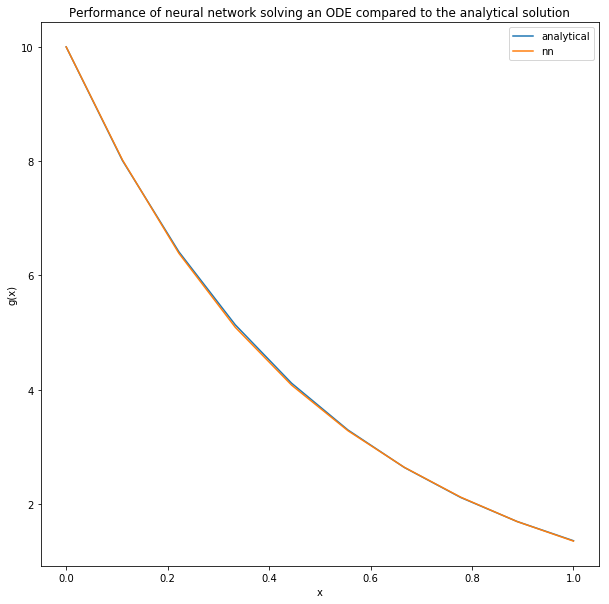

In [29]:
# Plot the results
plt.figure(figsize=(10,10))
plt.title('Performance of neural network solving an ODE compared to the analytical solution')
plt.plot(x, res_analytical)
plt.plot(x, res[0,:])
plt.legend(['analytical','nn'])
plt.xlabel('x')
plt.ylabel('g(x)')
plt.show()